In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns; sns.set()
import re
import sys
import urllib
import simplejson
import math
from sklearn.cluster import DBSCAN
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression as logist_reg
#from shapely.geometry import MultiPoint
from six.moves import  cPickle as pickle
%matplotlib inline
m10_eps = 10.0/6368673.0 

In [2]:
try:
    del violation
except:
    print("violation is not exist")
    pass
violation =  pd.read_csv('detroit-blight-violations.csv')

violation is not exist


//anaconda/envs/tensorflow3_5/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (6,10,11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
filter_lg = re.compile("\((.+)\)")
lat = np.zeros(len(violation.ViolationAddress))
lon = np.zeros(len(violation.ViolationAddress))
flag = 0
for x in violation.ViolationAddress: 
    try:
        #print(x)
        matchObj = filter_lg.search(x)
        tmp_cord = list(map(lambda x:  float(x), matchObj.group(1).split(',')))
        lat[flag] = tmp_cord[0]
        lon[flag] = tmp_cord[1]
    except ValueError:
        print("Oops, error happens")
    flag +=1

violation['lat'] = pd.Series(lat, index=violation.index)
violation['lng'] = pd.Series(lon, index=violation.index)

In [4]:
try:
    del crime
except:
    print("crime is not exist")
    pass
crime = pd.read_csv('detroit-crime.csv',dtype={'INCINO': str,'LOCATION': str})
crime.dtypes


crime is not exist


ROWNUM                     int64
CASEID                     int64
INCINO                    object
CATEGORY                  object
OFFENSEDESCRIPTION        object
STATEOFFENSEFILECLASS    float64
INCIDENTDATE              object
HOUR                       int64
SCA                      float64
PRECINCT                 float64
COUNCIL                   object
NEIGHBORHOOD              object
CENSUSTRACT              float64
ADDRESS                   object
LON                      float64
LAT                      float64
LOCATION                  object
dtype: object

In [5]:
try:
    del demol
except:
    print("demol is not exist")
    pass
demol = pd.DataFrame.from_csv('detroit-demolition-permits.tsv',sep='\t',header=0)


demol is not exist


In [6]:
try:
    del call311
except:
    print("call311 is not exist")
    pass

call311 = pd.read_csv('detroit-311.csv',dtype={'lat':np.float64, 'lng':np.float64})
call311.columns

call311 is not exist


Index(['ticket_id', 'city', 'issue_type', 'ticket_status', 'issue_description',
       'rating', 'ticket_closed_date_time', 'acknowledged_at',
       'ticket_created_date_time', 'ticket_last_updated_date_time', 'address',
       'lat', 'lng', 'location', 'image'],
      dtype='object')

In [7]:
googleGeocodeUrl = 'http://maps.googleapis.com/maps/api/geocode/json?'

def get_coordinates(query, from_sensor=False):
    query = query.encode('utf-8')
    params = {
        'address': query,
        'sensor': "true" if from_sensor else "false"
    }
    url = googleGeocodeUrl + urllib.parse.urlencode(params)
    json_response = urllib.request.urlopen(url)
    response = simplejson.loads(json_response.read())
    if response['results']:
        location = response['results'][0]['geometry']['location']
        latitude, longitude = location['lat'], location['lng']
        #print(response)
        #print(query, latitude, longitude
    else:
        latitude, longitude = None, None
        print (query+"<no results>")
    return latitude, longitude

In [8]:
filter_lg = re.compile("\((.+)\)")
lat = np.zeros(len(demol.site_location))
lon = np.zeros(len(demol.site_location))
flag = 0
for x in demol.site_location: 
    try:
        matchObj = filter_lg.search(x)
        tmp_cord = list(map(lambda x:  float(x), matchObj.group(1).split(',')))
        lat[flag] = tmp_cord[0]
        lon[flag] = tmp_cord[1]
    except:
        print("Oops, error happens "+str(flag))
        if x != None:
            try: 
                tmp_cord = get_coordinates(x)
                lat[flag] = tmp_cord[0]
                lon[flag] = tmp_cord[1]
            except:
                print("can not find coord using Google API \n")
                lat[flag] = 0
                lon[flag] =0
                pass
        else:
            lat[flag] =0;
            lon[flag] =0;
            
        print(x)
        print('\n')
        pass
    flag +=1

demol['lat'] = pd.Series(lat, index=demol.index)
demol['lng'] = pd.Series(lon, index=demol.index)

Oops, error happens 17
15860 W GRAND RIVER
Detroit, MI



Oops, error happens 22
15703 W GRAND RIVER
Detroit, MI



Oops, error happens 27
can not find coord using Google API 

13982 HOUSTON
Detroit, MI



Oops, error happens 87
10803 STRATMANN
Detroit, MI



Oops, error happens 88
15408 WEST PARKWAY
Detroit, MI



Oops, error happens 93
13803 E SEVEN
Detroit, MI



Oops, error happens 98
can not find coord using Google API 

14241 HOUSTON
Detroit, MI



Oops, error happens 143
8584 MARK
Detroit, MI



Oops, error happens 171
6438 JOHN
Detroit, MI



Oops, error happens 188
10852 STRATMANN
Detroit, MI



Oops, error happens 193
3955 MT
Detroit, MI



Oops, error happens 205
15231 E STATE
Detroit, MI



Oops, error happens 226
4720 THREE
Detroit, MI



Oops, error happens 334
6450 W EDSEL FORD
Detroit, MI



Oops, error happens 471
can not find coord using Google API 

nan


Oops, error happens 472
can not find coord using Google API 

nan


Oops, error happens 473
can not find coord us

# Referece: 
          #1. length of one degree in latitude: 111079.08m
          #2. length of one degree in longitude: 82460.44m
          #3. earth radius at detreri 6368.673 km 
          #3. the range of latitude we considered:
              lat ~ 42.2 , 42.5
              lng ~ -83.3 , -82.9

In [83]:
minlat = 42.2 
maxlat = 42.5 
minlng = -83.3
maxlng = -82.9
demol_nonzero = demol[ (demol.lat <maxlat ) & (demol.lat >minlat ) & (demol.lng <maxlng ) & (demol.lng >minlng )]
violation_nonzero = violation[(violation.lat <maxlat ) & (violation.lat >minlat ) & (violation.lng <maxlng ) & (violation.lng >minlng )]
crime_nonzero = crime[(crime.LAT <maxlat ) & (crime.LAT >minlat ) & (crime.LON <maxlng) & (crime.LON >minlng )]
call311_nonzero = call311[(call311.lat <maxlat ) & (call311.lat >minlat ) & (call311.lng <maxlng ) & (call311.lng >minlng )]

In [10]:
demol_nonzero.to_pickle('demol_nonzero.p')
violation_nonzero.to_pickle('violation_nonzero.p')
crime_nonzero.to_pickle('crime_nonzero.p')
call311_nonzero.to_pickle('call311_nonzero.p')

In [4]:
try:
    del grp_violation
    del grp_crime
    del grp_call311
    del grp_demol
except:
    pass

grp_violation = violation_nonzero#.drop_duplicates(['lat','lng'])
grp_crime = crime_nonzero#.drop_duplicates(['LON','LAT'])
grp_call311 = call311_nonzero#.drop_duplicates(['lat','lng'])
grp_demol = demol_nonzero#.drop_duplicates(['lat','lng'])

In [5]:
print(len(grp_violation))
print(len(grp_call311))
print(len(grp_crime))
print(len(grp_demol))
tmp_len = len(grp_violation) + len(grp_call311) + len(grp_demol) +len(grp_crime)
new_coord = np.zeros((tmp_len,2))
new_coord[:len(grp_violation),:] = grp_violation[['lat','lng']]
new_coord[len(grp_violation):len(grp_violation)+len(grp_call311),:] = grp_call311[['lat','lng']]
new_coord[len(grp_violation)+len(grp_call311):len(grp_violation)+len(grp_call311)+len(grp_crime),:] = grp_crime[['LAT','LON']]
#new_coord[len(grp_violation)+len(grp_call311)+len(grp_demol):,:] = grp_crime[['LAT','LON']
new_coord[-len(grp_demol):,:] = grp_demol[['lat','lng']]                                                                                                         

307804
19679
119443
6326


In [6]:

df = pd.DataFrame(new_coord)
#df = df.drop_duplicates([0,1])
file_coord = df[[0,1]]
#file_coord = file_coord/180.0*math.pi
file_coord.columns = ['lat','lng']
file_coord.to_pickle('file_coord.p')
file_coord = file_coord/180.0*math.pi


In [7]:
dbscan_rstl = DBSCAN(eps=m10_eps, min_samples=6, algorithm='ball_tree', metric='haversine').fit(file_coord)

In [16]:
try:
    del clusters
    del cluster_labels
except:
    pass

cluster_labels = dbscan_rstl.labels_
num_clusters = len(set(cluster_labels))
clusters = pd.Series([file_coord[cluster_labels == n]*180/math.pi for n in range(num_clusters)])

clusters.to_pickle('clusters.p')

In [17]:
#dbscan_rstl.components_.shape


def get_centermost_point(cluster):
    centroid = cluster.apply(lambda x : x.mean())
    return centroid

centermost_points = get_centermost_point(clusters)
centermost_points.columns = ['lat','lng']

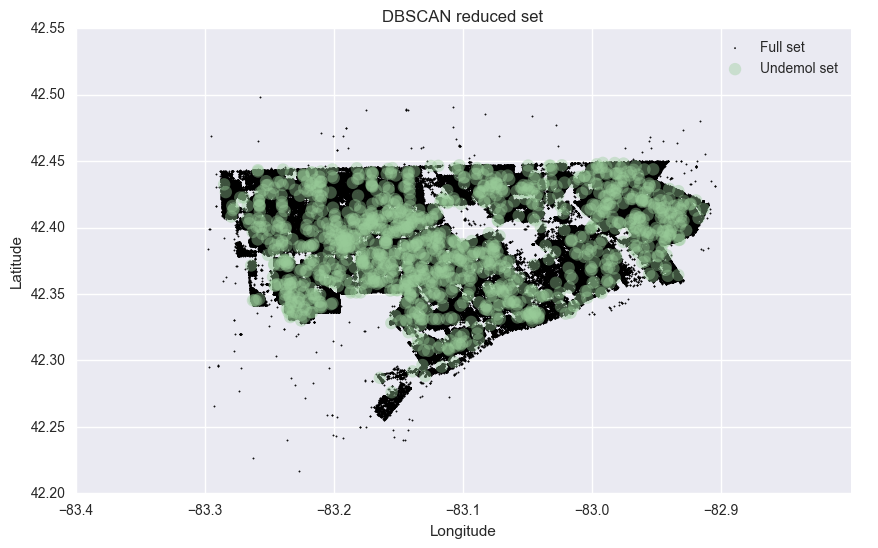

In [66]:
fig, ax = plt.subplots(figsize=[10, 6])
df_scatter = ax.scatter(file_coord.lng, file_coord.lat, c='k', alpha=0.9, s=1)
rs_scatter = ax.scatter(centermost_points.loc[rand_pick_nondemol_ind].lng, centermost_points.loc[rand_pick_nondemol_ind].lat, c='#99cc99', edgecolor='None', alpha=0.4, s=80)
#rs_scatter = ax.scatter(centermost_points.loc[rand_pick_nondemol_ind].lng, centermost_points.loc[rand_pick_nondemol_ind].lat, c='#99cc99', edgecolor='None', alpha=0.4, s=80)
#demol_scatter = ax.scatter(centermost_points.loc[fix_demol_ind].lng, centermost_points.loc[fix_demol_ind].lat, c='r', edgecolor='None', alpha=0.4, s=80)
#test_sc = ax.scatter(clusters[0][1], clusters[0][0], c='#99cc99', edgecolor='None', alpha=0.3, s=80)
ax.set_title('DBSCAN reduced set')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend([df_scatter, rs_scatter], ['Full set', 'Undemol set'], loc='upper right')
#ax.legend([df_scatter, rs_scatter,demol_scatter], ['Full set', 'Undemol set','Demol set'], loc='upper right')
plt.show()

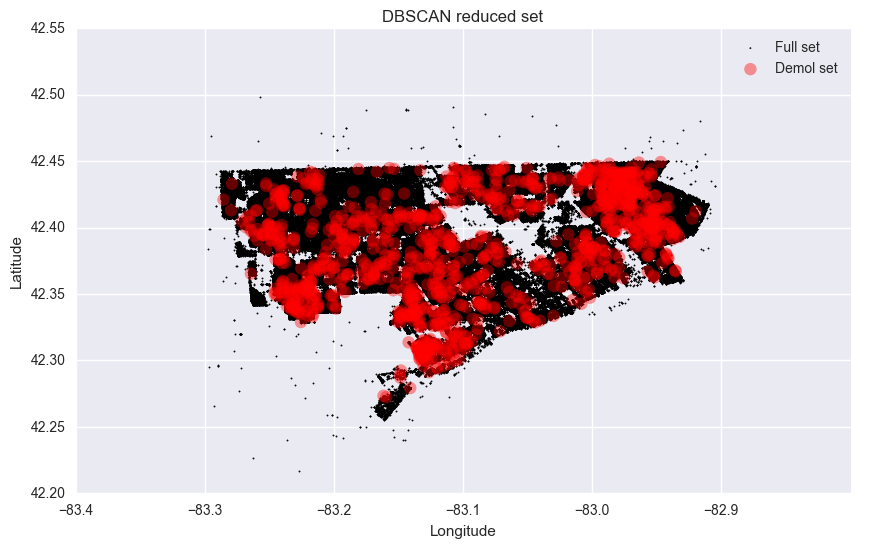

In [376]:
fig, ax = plt.subplots(figsize=[10, 6])
df_scatter = ax.scatter(file_coord.lng, file_coord.lat, c='k', alpha=0.9, s=1)
#rs_scatter = ax.scatter(centermost_points.lng[:5420], centermost_points.lat[:5420], c='#99cc99', edgecolor='None', alpha=0.4, s=80)
#rs_scatter = ax.scatter(centermost_points.loc[rand_pick_nondemol_ind].lng, centermost_points.loc[rand_pick_nondemol_ind].lat, c='#99cc99', edgecolor='None', alpha=0.4, s=80)
demol_scatter = ax.scatter(centermost_points.loc[fix_demol_ind].lng, centermost_points.loc[fix_demol_ind].lat, c='r', edgecolor='None', alpha=0.4, s=80)
#test_sc = ax.scatter(clusters[0][1], clusters[0][0], c='#99cc99', edgecolor='None', alpha=0.3, s=80)
ax.set_title('DBSCAN reduced set')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend([df_scatter,demol_scatter], ['Full set', 'Demol set'], loc='upper right')
plt.show()

In [19]:
# Readin all the saved data:


file_coord = pd.read_pickle('file_coord.p')
clusters = pd.read_pickle('clusters.p')
demol_nonzero = pd.read_pickle('demol_nonzero.p')
violation_nonzero = pd.read_pickle('violation_nonzero.p')
crime_nonzero = pd.read_pickle('crime_nonzero.p')
call311_nonzero = pd.read_pickle('call311_nonzero.p')


In [42]:
def find_ind(lat, file):
    try:
        tmp_a = [lat.index(row['lat']) for index, row in file.iterrows()]
    except:
        tmp_a = [lat.index(row['LAT']) for index, row in file.iterrows()]
    #tmp_a = [ lat.index(row['lat']) for row in file.iterrows() ]
    #for index, row in file.iterrows():
    #    print(lat.index(row['lat'])) 
    tmp_a = np.asarray(tmp_a)
    return tmp_a

In [21]:
demol_coord_ind =   file_coord.index[-len(demol_nonzero):]#find_ind(file_coord['lat'].tolist(),demol_nonzero)

In [22]:
violation_coord_ind = file_coord.index[:len(grp_violation)]

In [23]:
crime_nonzero_ind = file_coord.index[len(grp_violation)+len(grp_call311):len(grp_violation)+len(grp_call311)+len(grp_crime)]#find_ind(file_coord['lat'].tolist(),crime_nonzero)

In [24]:
call311_nonzero_ind = file_coord.index[len(grp_violation):len(grp_violation)+len(grp_call311)]

In [25]:
demol_nonzero['coord_ind'] = demol_coord_ind.tolist()
violation_nonzero['coord_ind'] = violation_coord_ind.tolist()
crime_nonzero['coord_ind'] = crime_nonzero_ind.tolist()
call311_nonzero['coord_ind'] = call311_nonzero_ind.tolist()

In [26]:
demol_nonzero.to_pickle('demol_nonzero.p')
violation_nonzero.to_pickle('violation_nonzero.p')
crime_nonzero.to_pickle('crime_nonzero.p')
call311_nonzero.to_pickle('call311_nonzero.p')

In [27]:
file_coord = pd.read_pickle('file_coord.p')
clusters = pd.read_pickle('clusters.p')
demol_nonzero = pd.read_pickle('demol_nonzero.p')
violation_nonzero = pd.read_pickle('violation_nonzero.p')
crime_nonzero = pd.read_pickle('crime_nonzero.p')
call311_nonzero = pd.read_pickle('call311_nonzero.p')


In [28]:
#demol_nonzero['coord_ind']
#test1 = file_coord.index
def find_coord_typeind(type_coord_ind, fcoord):
    test1 = type_coord_ind.value_counts()
#test = [ lambda x : test1[x] if x in test1.index else 0,file_coord.index.tolist()]
    test = np.zeros(len(fcoord))
    for x in range(len(fcoord)):
        if x in test1.index:
            test[x] = test1[x]
        else:
            test[x] = 0 
    return test

In [29]:
file_coord['demol_count'] = find_coord_typeind(demol_nonzero.coord_ind,file_coord)
file_coord['call311_count'] = find_coord_typeind(call311_nonzero.coord_ind,file_coord)
file_coord['violation_count'] = find_coord_typeind(violation_nonzero.coord_ind,file_coord)
file_coord['crime_count'] = find_coord_typeind(crime_nonzero.coord_ind,file_coord)

In [42]:
test = np.zeros(len(clusters))
i = 0
for x in clusters:
    test[i] = file_coord.loc[x.index].demol_count.sum()
    i = i+1
    if i % 200 == 0:
        print(i)

200
400
600
800
1000
1200
1400
1600
1800
2000
2200
2400
2600
2800
3000
3200
3400
3600
3800
4000
4200
4400
4600
4800
5000
5200
5400
5600
5800
6000
6200
6400
6600
6800
7000
7200
7400
7600
7800
8000
8200
8400
8600
8800
9000
9200
9400
9600
9800
10000
10200
10400
10600
10800
11000
11200
11400
11600
11800
12000
12200
12400
12600
12800
13000
13200
13400
13600
13800
14000
14200
14400
14600
14800
15000
15200
15400
15600
15800
16000
16200
16400
16600


In [43]:
#cluster_demol_count = clusters.apply(lambda x : file_coord.loc[x.index].demol_count.sum())
#plt.plot(centermost_points['demol_count'][100:])

centermost_points['demol_count'] = test
#centermost_points['call311_count'].isnull().sum()

#centermost_points.to_pickle('centermost_points.p')

In [44]:
file_coord.to_pickle('file_coord.p')
clusters.to_pickle('clusters.p')
demol_nonzero.to_pickle('demol_nonzero.p')
violation_nonzero.to_pickle('violation_nonzero.p')
crime_nonzero.to_pickle('crime_nonzero.p')
call311_nonzero.to_pickle('call311_nonzero.p')
centermost_points.to_pickle('centermost_points.p')

In [2]:
file_coord = pd.read_pickle('file_coord.p')
clusters = pd.read_pickle('clusters.p')
demol_nonzero = pd.read_pickle('demol_nonzero.p')
violation_nonzero = pd.read_pickle('violation_nonzero.p')
crime_nonzero = pd.read_pickle('crime_nonzero.p')
call311_nonzero = pd.read_pickle('call311_nonzero.p')
centermost_points = pd.read_pickle('centermost_points.p')

# Define function that  takes in [lat, lng] and returns nearest cluster
## Special cases: the lat and lng fall out of the desired range

In [98]:
def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(math.radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = math.sin(dlat/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon/2)**2
    c = 2 * math.asin(math.sqrt(a)) 
    r = 6368673.0  # Radius of earth in meters.
    return c * r

def find_nrst_cluster(tmp_cord,cluster_cntcoord,cluster,eps):
    """
    Calculate the min distance bwteen tmp_cord and the clusters
    """
    # for point in the range
    if(tmp_cord[0] <42.5 and tmp_cord[0]> 42.2 and tmp_cord[1]< -82.9 and tmp_cord[-1]> -83.3  ):
        test_array = centermost_points.apply(lambda row: haversine(row['lng'],row['lat'],tmp_cord[1],tmp_cord[0]), axis=1)
        min_dist= test_array.min()
        min_ind = test_array.argmin()
        if min_dist <= eps:
            return min_ind
        else:
        #for row in cluster[min_ind].itertuples():
            tmp_dist = np.array([haversine(row[2],row[1],tmp_cord[1],tmp_cord[0]) for row in cluster[min_ind].itertuples()])
            min_dist = tmp_dist.min()
            if(min_dist <= eps):
                return min_ind
            else:
                return  -1
    # for point outside the range
    else:
        return -1
            
    

In [47]:
demol_size

1376

In [155]:
demol_cluster_index = centermost_points.demol_count >0.9
test = centermost_points.demol_count <0.9
nondemol_size = test.sum()
demol_size = demol_cluster_index.sum()
rand_list = np.random.choice(nondemol_size, demol_size, replace=False)

In [156]:
tmp_ind = centermost_points.loc[centermost_points.demol_count <0.9].index
rand_pick_nondemol_ind = tmp_ind[rand_list]
fix_demol_ind = centermost_points.loc[centermost_points.demol_count >0.9].index

# Try two types of input data
## 1. Use time distributions
## 2. Use event counts

In [151]:
#test_rand =np.concatenate((cent_violation_hist[rand_pick_nondemol_ind,:],cent_call311_hist[rand_pick_nondemol_ind,:], cent_crime_hist[rand_pick_nondemol_ind,:]),axis=1) # centermost_points.loc[rand_pick_nondemol_ind][['violation_count','call311_count','crime_count']]
#test_fix =np.concatenate((cent_violation_hist[fix_demol_ind,:],cent_call311_hist[fix_demol_ind,:], cent_crime_hist[fix_demol_ind,:]),axis=1)#centermost_points.loc[fix_demol_ind][['violation_count','call311_count','crime_count']]
#train_x = pd.concat([test_rand,test_fix])
#test_rand = centermost_points.loc[rand_pick_nondemol_ind][['violation_count','call311_count','crime_count']]
#test_fix = centermost_points.loc[fix_demol_ind][['violation_count','call311_count','crime_count']]


test_rand =cent_violation_hist[rand_pick_nondemol_ind,:] #np.concatenate((cent_violation_hist[rand_pick_nondemol_ind,:],cent_call311_hist[rand_pick_nondemol_ind,:], cent_crime_hist[rand_pick_nondemol_ind,:]),axis=1) # centermost_points.loc[rand_pick_nondemol_ind][['violation_count','call311_count','crime_count']]
test_fix =cent_violation_hist[fix_demol_ind,:] #np.concatenate((cent_violation_hist[fix_demol_ind,:],cent_call311_hist[fix_demol_ind,:], cent_crime_hist[fix_demol_ind,:]),axis=1)#centermost_points.loc[fix_demol_ind][['violation_count','call311_count','crime_count']]

train_x =np.concatenate((test_fix,test_rand))#
train_x.shape
#train_x = pd.concat([centermost_points.loc[rand_pick_nondemol_ind].[['violation_count','call311_count','crime_count']],centermost_points.loc[fix_demol_ind].[['violation_count','call311_count','crime_count']]])

(2752, 23)

In [152]:
test_rand2 = centermost_points.loc[rand_pick_nondemol_ind][['violation_count','call311_count','crime_count']]
test_fix2 =centermost_points.loc[fix_demol_ind][['violation_count','call311_count','crime_count']]
#train_x = pd.concat([test_rand,test_fix])
#test_rand = centermost_points.loc[rand_pick_nondemol_ind][['violation_count','call311_count','crime_count']]
#test_fix = centermost_points.loc[fix_demol_ind][['violation_count','call311_count','crime_count']]
train_x2 = pd.concat([test_fix2,test_rand2])
train_x2.shape



(2752, 3)

In [127]:
test_rand3 =cent_violation_fine_hist[rand_pick_nondemol_ind,:]# centermost_points.loc[rand_pick_nondemol_ind][['violation_count','call311_count','crime_count']]
test_fix3 =cent_violation_fine_hist[fix_demol_ind,:]#centermost_points.loc[fix_demol_ind][['violation_count','call311_count','crime_count']]
#train_x = pd.concat([test_rand,test_fix])
#test_rand = centermost_points.loc[rand_pick_nondemol_ind][['violation_count','call311_count','crime_count']]
#test_fix = centermost_points.loc[fix_demol_ind][['violation_count','call311_count','crime_count']]
train_x3 =np.concatenate((test_fix3,test_rand3))#
train_x3.shape

(2752, 19)

In [65]:
train_y = np.zeros((len(train_x)))
train_y[:int(demol_size)] = 1 
1- train_y.mean()

0.5

In [66]:
lr_handle = logist_reg(penalty='l1', dual=False, tol=0.0001, C=1, max_iter=1000)

In [68]:
test = lr_handle.fit(train_x,train_y)
abs(test.coef_)

array([[ 1.37856172,  0.12536216,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.75580512,  0.68577137,
         1.03469244,  1.21166005,  0.8632687 ,  1.03530933,  0.76397464,
         0.19240355,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  2.23650192,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.54209335,  0.38779754,  1.1410404 ,  0.27583114,
         0.        ,  0.07728295,  0.2031514 ,  0.        ,  0.26382154,
         0.        ,  0.        ,  0.        ,  0.        ,  0.91433229,
         0.        ,  0.70774055,  0.7315676 ,  0.02680514,  0.40872044,
         0.        ,  0.        ,  0.        ,  0.25073269,  0.2161762 ,
         0.13183512,  0.16812746,  0.        ,  0.44175813,  0.40104643,
         0.        ,  0.23776688,  0.38485034,  0.        ,  0.        ,
         0.        ,  0.24599553,  0.28146588,  0.2

In [370]:
violation_fine_feature = (abs(test.coef_)>0.01)[0,:]
violation_fine_feature.sum()

12

In [147]:
feature_select = (abs(test.coef_)>0.5)[0,:]
train_x3 = np.concatenate(( train_x[:,feature_select],train_x2[['violation_count','call311_count','crime_count']].values),axis=1)

AttributeError: 'numpy.ndarray' object has no attribute 'coef_'

In [71]:
from sklearn import svm

In [98]:
svm_machine = svm.SVC(C =0.5 , kernel='linear')

In [99]:
scores = cross_val_score(svm_machine, train_x[:,(abs(test.coef_)>0.2)[0,:]], train_y, cv=5)

In [100]:
scores.mean()

0.80000017153960923

#Try Adaboost 

In [72]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

In [59]:
adaboost_machine = AdaBoostClassifier(DecisionTreeClassifier(max_depth=10),n_estimators = 100 )

In [60]:
scores = cross_val_score(adaboost_machine, train_x3, train_y, cv=5)

In [61]:
scores.mean()

0.75655600298562031

# Try to use stratified split to do the cross validation:


In [70]:
from sklearn.model_selection import StratifiedShuffleSplit
import datetime

## use the two sets of data to do CV 

In [154]:
#Strat_x = train_x2[['violation_count','call311_count','crime_count']].values
Strat_x = np.concatenate((train_x2[['violation_count','call311_count','crime_count']].values,train_x),axis=1)
Strat_y = train_y

    
def strat_cv_custom(Input_x,Input_y,method,split ):
    
    sss = StratifiedShuffleSplit(n_splits=split, test_size=0.2, random_state=datetime.datetime.now().second)
    acc = np.zeros(split)
    flag = 0 
    for train_index, test_index in sss.split(Input_x, Input_y): 
        
        X_train, X_test = Input_x[train_index], Input_x[test_index]
        y_train, y_test = Input_y[train_index], Input_y[test_index]
        tmp_acc = (method.fit(X_train,y_train).predict(X_test) == y_test).sum()/len(y_test)
        #print(tmp_acc)
        acc[flag] = tmp_acc
        
        flag +=1
    return acc

for i in np.linspace(0.1,1,num=10):
    svm_machine = svm.SVC(C = 1.2, kernel='rbf',gamma=i)
    score  = strat_cv_custom(Strat_x,Strat_y,svm_machine,5)
    print(str(score.mean())+" at gamma="+str(i))

0.613430127042 at gamma=0.1
0.613793103448 at gamma=0.2
0.605807622505 at gamma=0.3
0.611978221416 at gamma=0.4
0.614156079855 at gamma=0.5
0.61778584392 at gamma=0.6
0.61887477314 at gamma=0.7
0.610526315789 at gamma=0.8
0.60943738657 at gamma=0.9
0.620326678766 at gamma=1.0


In [75]:
for i in np.linspace(1.0,10,num=10):
    svm_machine = svm.SVC(C = i, kernel='rbf',gamma=0.3)
    score  = strat_cv_custom(Strat_x,Strat_y,svm_machine,5)
    print(str(score.mean())+" at C="+str(i))

0.611978221416 at C=1.0
0.616696914701 at C=2.0
0.625045372051 at C=3.0
0.613067150635 at C=4.0
0.60834845735 at C=5.0
0.624319419238 at C=6.0
0.615607985481 at C=7.0
0.628675136116 at C=8.0
0.612704174229 at C=9.0
0.609074410163 at C=10.0


In [67]:
Strat_x = train_x2[['violation_count','call311_count','crime_count']].values
Strat_y = train_y

for i in np.linspace(1,10,num=10):
    #svm_machine = svm.SVC(C = 5, kernel='rbf',gamma=i)
    lgist_machine = logist_reg(penalty='l2', dual=False, tol=0.0001, C=i, max_iter=1000)
    score  = strat_cv_custom(Strat_x,Strat_y,lgist_machine,5)
    print(str(score.mean())+" at gamma="+str(i))

0.800338123415 at gamma=1.0
0.800845308538 at gamma=2.0
0.800845308538 at gamma=3.0
0.800845308538 at gamma=4.0
0.800845308538 at gamma=5.0
0.800845308538 at gamma=6.0
0.8 at gamma=7.0
0.8 at gamma=8.0
0.8 at gamma=9.0
0.8 at gamma=10.0


In [114]:
#feature_select = (abs(test.coef_)>0.01)[0,:]
Strat_x = train_x
Strat_y = train_y

    
def strat_cv_custom(Input_x,Input_y,method,split ):
    
    sss = StratifiedShuffleSplit(n_splits=split, test_size=0.2, random_state=datetime.datetime.now().second)
    acc = np.zeros(split)
    flag = 0 
    for train_index, test_index in sss.split(Input_x, Input_y): 
        
        X_train, X_test = Input_x[train_index], Input_x[test_index]
        y_train, y_test = Input_y[train_index], Input_y[test_index]

        tmp_acc = (method.fit(X_train,y_train).predict(X_test) == y_test).sum()/len(y_test)
        #print(tmp_acc)
        acc[flag] = tmp_acc
        
        flag +=1
    return acc

for i in np.linspace(0.1,1,num=10):
    svm_machine = svm.SVC(C = 5, kernel='rbf',gamma=i)
    score  = strat_cv_custom(Strat_x,Strat_y,svm_machine,5)
    print(str(score.mean())+" at gamma="+str(i))



0.524500907441 at gamma=0.1
0.53502722323 at gamma=0.2
0.541560798548 at gamma=0.3
0.553176043557 at gamma=0.4
0.553539019964 at gamma=0.5
0.536842105263 at gamma=0.6
0.542286751361 at gamma=0.7
0.526315789474 at gamma=0.8
0.534301270417 at gamma=0.9
0.541560798548 at gamma=1.0


In [73]:
feature_select = (abs(test.coef_)>0.5)[0,:]
Strat_x = train_x[:,feature_select]
Strat_y = train_y

for i in np.linspace(2,11,num=10):
    svm_machine = svm.SVC(C = i, kernel='rbf',gamma=0.6)
    score  = strat_cv_custom(Strat_x,Strat_y,svm_machine,5)
    print(str(score.mean())+" at C="+str(i))

0.799830938292 at C=2.0
0.800338123415 at C=3.0
0.800169061708 at C=4.0
0.80067624683 at C=5.0
0.800338123415 at C=6.0
0.800338123415 at C=7.0
0.800169061708 at C=8.0
0.800338123415 at C=9.0
0.800507185123 at C=10.0
0.799830938292 at C=11.0


In [78]:
feature_select = (abs(test.coef_)>0.5)[0,:]
Strat_x = train_x[:,feature_select]
Strat_y = train_y

for i in np.linspace(1,5,num=5):
    adaboost_machine = AdaBoostClassifier(DecisionTreeClassifier(max_depth=int(i)),n_estimators = 70 )
    score  = strat_cv_custom(Strat_x,Strat_y,adaboost_machine,5)
    print(str(score.mean())+" at n_est="+str(i))

0.575317604356 at n_est=1.0
0.560798548094 at n_est=2.0
0.556079854809 at n_est=3.0
0.555716878403 at n_est=4.0
0.549909255898 at n_est=5.0


In [133]:
from sklearn import preprocessing
Strat_x =train_x3#[:,violation_fine_feature]
Strat_y = train_y

    
def strat_cv_custom(Input_x,Input_y,method,split ):
    
    sss = StratifiedShuffleSplit(n_splits=split, test_size=0.2, random_state=datetime.datetime.now().second)
    acc = np.zeros(split)
    flag = 0 
    for train_index, test_index in sss.split(Input_x, Input_y): 
        
        X_train, X_test = Input_x[train_index], Input_x[test_index]
        y_train, y_test = Input_y[train_index], Input_y[test_index]
        tmp_acc = (method.fit(X_train,y_train).predict(X_test) == y_test).sum()/len(y_test)
        #print(tmp_acc)
        acc[flag] = tmp_acc
        
        flag +=1
    return acc

for i in np.linspace(10,100,num=10):
    adaboost_machine = AdaBoostClassifier(DecisionTreeClassifier(max_depth= 11 ),n_estimators = int(i))
    #svm_machine = svm.SVC(C = i, kernel='rbf',gamma=i)
    score  = strat_cv_custom(Strat_x,Strat_y,adaboost_machine,5)
    print(str(score.mean())+" at gamma="+str(i))

0.582577132486 at gamma=10.0
0.578221415608 at gamma=20.0
0.587658802178 at gamma=30.0
0.564065335753 at gamma=40.0
0.550272232305 at gamma=50.0
0.567695099819 at gamma=60.0
0.58221415608 at gamma=70.0
0.565154264973 at gamma=80.0
0.57277676951 at gamma=90.0
0.574228675136 at gamma=100.0


In [143]:
feature_select = (abs(test.coef_)>0.5)[0,:]
Strat_x = train_x[:,feature_select]
Strat_y = train_y
adaboost_machine = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),n_estimators = 50 )
adaboost_machine.fit(Strat_x,Strat_y)
from sklearn.externals import joblib
filename = './adaboost_model_hist.pkl'
joblib.dump(adaboost_machine, filename) 

['./adaboost_model_hist.pkl']

In [144]:
Strat_x = train_x2[['violation_count','call311_count','crime_count']].values
Strat_y = train_y
svm_machine = svm.SVC(C = 1.2, kernel='rbf',gamma=0.2)
svm_machine.fit(Strat_x,Strat_y)
from sklearn.externals import joblib
filename = './SVM_model_count.pkl'
joblib.dump(svm_machine, filename) 

['./SVM_model_count.pkl']

# Try to set up a linear combination of the two models

In [150]:
#feature_select = (abs(test.coef_)>0.01)[0,:]
Strat_x = train_x#[:,feature_select]
Strat_y = train_y

Strat_x2 = train_x2[['violation_count','call311_count','crime_count']].values

split = 5 

sss = StratifiedShuffleSplit(n_splits=split, test_size=0.2, random_state=datetime.datetime.now().second)
#tmp_y = np.zeros((len(Strat_y),2))
score = 0 
for train_index, test_index in sss.split(Strat_x, Strat_y): 
        
    X_train, X_test = Strat_x[train_index], Strat_x[test_index]
    X_train2, X_test2 = Strat_x2[train_index], Strat_x2[test_index]
    
    y_train, y_test = Strat_y[train_index], Strat_y[test_index]
    
    # init two models
    adaboost_machine = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),n_estimators = 50 )
    svm_machine = svm.SVC(C = 5.0, kernel='rbf',gamma=0.2)
    # fit the models
    adaboost_machine.fit(X_train,y_train)
    svm_machine.fit(X_train2,y_train)
    
    tmp_y = np.zeros((len(y_train),2))
    #Predict1
    tmp_y[:,0] = adaboost_machine.predict(X_train)
    tmp_y[:,1] = svm_machine.predict(X_train2)
    
    #logisti_reg on the combined model
    lr_handle = logist_reg(penalty='l2', dual=False, tol=0.0001, C=5, max_iter=2000)
    lr_handle.fit(tmp_y,y_train)
    
    tmp_y = np.zeros((len(y_test),2))
    #Predict2
    tmp_y[:,0] = adaboost_machine.predict(X_test)
    tmp_y[:,1] = svm_machine.predict(X_test2)
    
    #final predict
    
    tmp_acc = (lr_handle.predict(tmp_y) == y_test).sum()/len(y_test)
    
    score += tmp_acc
    
    
    print(tmp_acc)
    #acc[flag] = tmp_acc
        
print("final score: "+str(score/split))

0.5444646098
0.584392014519
0.600725952813
0.59165154265
0.589836660617
final score: 0.58221415608


# Try to extract hour distrubutions for each data type

In [50]:
#def parse_hour_format(hour_string):
#pd.datetime.strptime(date_string, '%H:%M')
testviolation_data = pd.to_datetime(violation_nonzero.TicketIssuedTime)
testcall_data = pd.to_datetime(call311_nonzero.ticket_created_date_time)

In [51]:
violation_nonzero['hour'] = testviolation_data.dt.hour
call311_nonzero['hour'] = testcall_data.dt.hour

In [56]:
test = np.zeros((len(clusters),23))
i = 0
for x in clusters:
    tmp_col = crime_nonzero['coord_ind'].isin(x.index)
    
    if(tmp_col.sum() >0) :
        test[i,:],tmp_bins  = np.histogram(crime_nonzero[tmp_col].HOUR,bins=range(24),density=True)
   
    if i % 100 == 0:
        print(i)
    i =i+1

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700


In [57]:
#cent_crime_hist = test
#cent_call311_hist = test
#cent_violation_hist= test
#np.savetxt('cent_crime_hist.out', cent_crime_hist) 
#np.savetxt('cent_call311_hist.out', cent_call311_hist) 
#np.savetxt('cent_violation_hist.out', cent_violation_hist) 


In [112]:
cent_crime_hist = np.loadtxt('cent_crime_hist.out')
cent_call311_hist = np.loadtxt('cent_call311_hist.out')
cent_violation_hist = np.loadtxt('cent_violation_hist.out')

 ...]

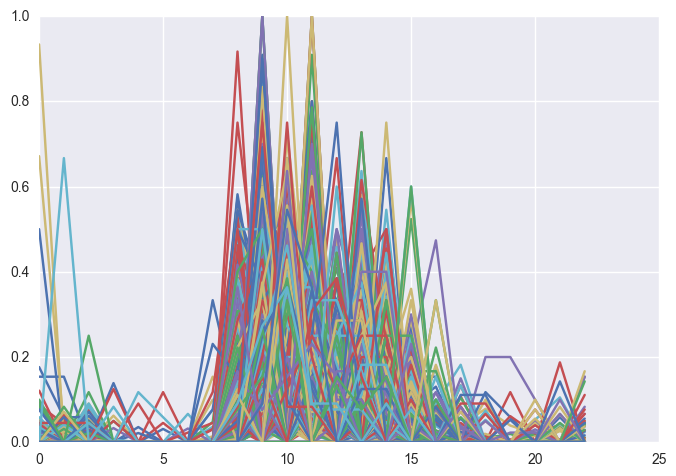

In [131]:
#plt.plot(np.transpose(cent_violation_hist[rand_pick_nondemol_ind,:]))
plt.plot(np.transpose(cent_violation_hist[fix_demol_ind,:]))

//anaconda/envs/tensorflow3_5/lib/python3.5/site-packages/matplotlib/__init__.py:898: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


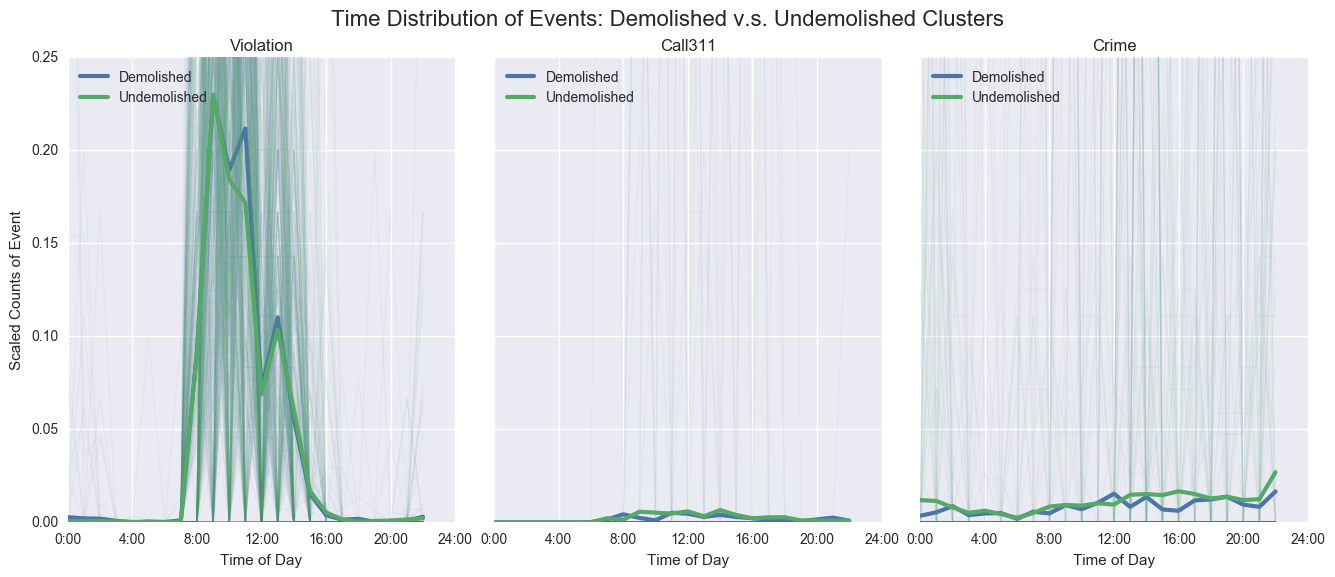

In [105]:

fig, ax = plt.subplots(1, 3, figsize=(16, 6), sharex=True, sharey=True)
fig.subplots_adjust(wspace=0.1)
fmt = plt.FuncFormatter(lambda x, *args: '{0}:00'.format(int(x)))
data_set  = [cent_violation_hist,cent_call311_hist,cent_crime_hist]
index_set = [fix_demol_ind,rand_pick_nondemol_ind]
flag = 0 
color_cycle = plt.rcParams['axes.color_cycle']
col_name = ['Demolished','Undemolished']
for x in data_set:
    axi = ax[flag]
    for i, col in enumerate(index_set):
        vals = x[col,:].transpose()
        axi.plot(range(23), vals[:,:200],color=color_cycle[i], lw=1, alpha=0.05)
        vals = x[col,:].transpose()
        axi.plot(range(23), vals.mean(axis=1),color=color_cycle[i], lw=3, label=col_name[i])
                 
    axi.xaxis.set_major_locator(plt.MultipleLocator(4))
    axi.xaxis.set_major_formatter(fmt)   
    axi.set_ylim(0, 0.25)
    if(flag ==0):
        axi.set_title('Violation' )
    elif(flag ==1):
        axi.set_title('Call311' )
    else:
        axi.set_title('Crime' )
    axi.legend(loc='upper left')
    axi.set_xlabel('Time of Day')
    flag +=1 
ax[0].set_ylabel('Scaled Counts of Event')
fig.suptitle('Time Distribution of Events: Demolished v.s. Undemolished Clusters', size=16);

fig.savefig('./comp_hourly_event.png', bbox_inches='tight')

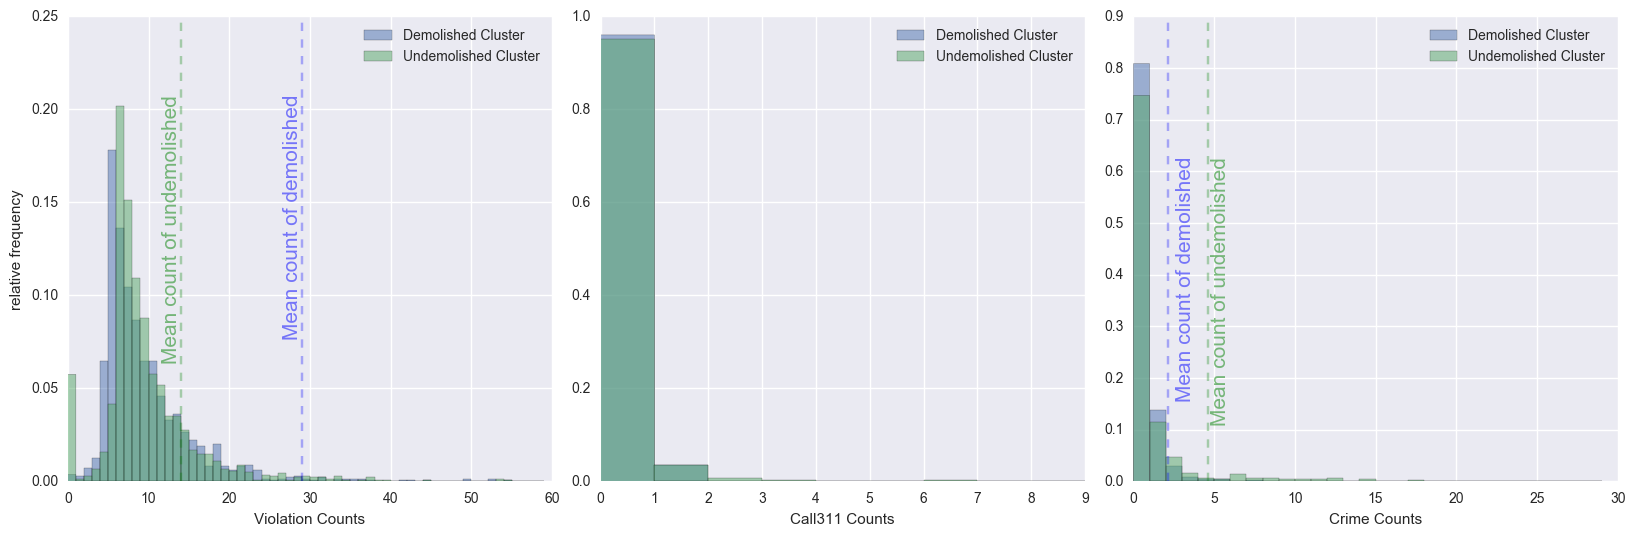

In [111]:
fig, ax = plt.subplots(1, 3, figsize=(20, 6))
fig.subplots_adjust(wspace=0.1)

#data_set= [cent_violation_hist,cent_call311_hist,cent_crime_hist]
#test_rand2
#test_fix2

test_fix2['violation_count'].hist(bins=np.arange(60), alpha=0.5, normed=True, ax=ax[0]);
test_rand2['violation_count'].hist(bins=np.arange(60), alpha=0.5, normed=True, ax=ax[0]);
ax[0].set_xlabel('Violation Counts')
ax[0].set_ylabel('relative frequency')
ax[0].text(29, 0.2, "Mean count of demolished", ha='right',
           size=15, rotation=90, alpha=0.5, color='blue')
ax[0].legend(['Demolished Cluster','Undemolished Cluster'])

ax[0].axvline(29, linestyle='--', color='blue', alpha=0.3);

ax[0].text(14, 0.2, "Mean count of undemolished", ha='right',
           size=15, rotation=90, alpha=0.5, color='green')
ax[0].axvline(14, linestyle='--', color='green', alpha=0.3);


test_fix2['call311_count'].hist(bins=np.arange(10), alpha=0.5, normed=True, ax=ax[1]);
test_rand2['call311_count'].hist(bins=np.arange(10), alpha=0.5, normed=True, ax=ax[1]);
ax[1].set_xlabel('Call311 Counts')
#ax[0].text(34, 0.09, "Free Trips\n\nAdditional Fee", ha='right',
#           size=18, rotation=90, alpha=0.5, color='red')
ax[1].legend(['Demolished Cluster','Undemolished Cluster'])



test_fix2['crime_count'].hist(bins=np.arange(30), alpha=0.5, normed=True, ax=ax[2]);
test_rand2['crime_count'].hist(bins=np.arange(30), alpha=0.5, normed=True, ax=ax[2]);
ax[2].set_xlabel('Crime Counts')

ax[2].legend(['Demolished Cluster','Undemolished Cluster'])
ax[2].text(3.8, 0.6, "Mean count of demolished", ha='right',
           size=15, rotation=90, alpha=0.5, color='blue')
ax[2].legend(['Demolished Cluster','Undemolished Cluster'])

ax[2].axvline(2.17, linestyle='--', color='blue', alpha=0.3);

ax[2].text(6.0, 0.6, "Mean count of undemolished", ha='right',
           size=15, rotation=90, alpha=0.5, color='green')
ax[2].axvline(4.62, linestyle='--', color='green', alpha=0.3);



fig.savefig('./hist_type_count.png', bbox_inches='tight')

0            22-2-20
1            22-2-22
2            22-2-22
3            22-2-45
4            22-2-22
5            22-2-45
6            22-2-22
7            22-2-22
8            22-2-22
9            22-2-22
10           22-2-22
11           22-2-22
12           22-2-22
13           22-2-22
14           22-2-22
15           22-2-22
16           22-2-22
17           22-2-22
18           22-2-22
19           22-2-22
20           22-2-22
21           22-2-22
22           22-2-22
23           22-2-22
24           22-2-22
25           22-2-22
26        22-2-88(a)
27           22-2-17
28           22-2-22
29           22-2-17
             ...    
307774       9-1-104
307775       9-1-104
307776       9-1-104
307777       9-1-104
307778       9-1-104
307779       9-1-104
307780       9-1-104
307781       9-1-104
307782    22-2-88(b)
307783       9-1-104
307784       22-2-43
307785    22-2-88(b)
307786       9-1-104
307787    22-2-88(b)
307788       9-1-104
307789    22-2-88(b)
307790       

In [120]:
violation_nonzero['fine_amount'] =  violation_nonzero['FineAmt'].apply(lambda x :  0 if type(x) is float else float(str(x)[1:]) )


In [125]:
test = np.zeros((len(clusters),19))
i = 0
for x in clusters:
    tmp_col = violation_nonzero['coord_ind'].isin(x.index)
    
    if(tmp_col.sum() >0) :
        test[i,:],tmp_bins  = np.histogram(violation_nonzero[tmp_col].fine_amount,bins=np.linspace(0,4000,num=20),density=False)
   
    if i % 200 == 0:
        print(i)
    i =i+1

0
200
400
600
800
1000
1200
1400
1600
1800
2000
2200
2400
2600
2800
3000
3200
3400
3600
3800
4000
4200
4400
4600
4800
5000
5200
5400
5600
5800
6000
6200
6400
6600
6800
7000
7200
7400
7600
7800
8000
8200
8400
8600
8800
9000
9200
9400
9600
9800
10000
10200
10400
10600
10800
11000
11200
11400
11600
11800
12000
12200
12400
12600
12800
13000
13200
13400
13600
13800
14000
14200
14400
14600
14800
15000
15200
15400
15600
15800
16000
16200
16400
16600


In [126]:
cent_violation_fine_hist= test
np.savetxt('cent_violation_fine_hist.out', cent_violation_fine_hist) 

In [159]:
testdtviolation_data = pd.to_datetime(violation_nonzero.TicketIssuedDT)

ValueError: year is out of range

In [161]:
violation_nonzero.TicketIssuedTime

0         12:00:00
1         10:15:00
2         10:35:00
3         10:45:00
4         11:10:00
5         12:45:00
6         12:45:00
7         13:05:00
8         09:45:00
9         10:05:00
10        10:00:00
11        10:15:00
12        10:45:00
13        12:15:00
14        12:35:00
15        12:50:00
16        10:20:00
17        10:50:00
18        12:25:00
19        09:35:00
20        09:45:00
21        09:50:00
22        10:10:00
23        10:30:00
24        10:45:00
25        11:00:00
26        11:45:00
27        11:20:00
28        12:00:00
29        11:15:00
            ...   
307774    11:05:00
307775    11:10:00
307776    10:15:00
307777    10:05:00
307778    11:20:00
307779    11:25:00
307780    11:35:00
307781    11:40:00
307782    10:25:00
307783    10:25:00
307784    10:25:00
307785    10:10:00
307786    10:10:00
307787    10:45:00
307788    10:45:00
307789    10:50:00
307790    10:50:00
307791    10:30:00
307792    11:00:00
307793    11:05:00
307794    13:05:00
307795    11